In [200]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy.signal import butter, filtfilt, find_peaks, peak_prominences
from typing import Tuple

from truth import IeeeGroundTruth

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [201]:
150/60

2.5

In [202]:
peak_height = 0.25
CHROM_SETTINGS = {
    'fr': 30,  # frame rate
    'freq': (0.5, 2.5),  # bandpass frequency range
    'bandpass_order': 4,  # bandpass filter order
    'moving_avg_window': 6,  # moving average window size for smoothing
    'peak_height': peak_height,  # min peak height for peak detection
    'slice_filter_thresh': 2,  # min number of peaks allowed in a slice of the signal
    'stringent_perc': 85,  # more stringent percentile for peak filtering
    'non_stringent_perc': 75,  # less stringent percentile for peak filtering
}

## 0. Signal Processing Methods

In [203]:
def bandpass(signal: np.ndarray, fr: int, freq: Tuple[float, float], order: int):
    """
    Apply bandpass filter to the given signal.

    fr - frame rate
    freq - tuple of low and high frequencies for the bandpass filter
    order - order of the bandpass filter
    """

    # nyquist frequency stays hardcoded at half the frame rate
    nyquist_freq = 0.5 * fr
    
    # low and high values for butter created using nyquist
    low = freq[0] / nyquist_freq
    high = freq[1] / nyquist_freq
    
    # apply the filter
    b, a = butter(order, [low, high], btype = 'band')
    filtered = filtfilt(b, a, signal)
    return filtered

def detrend_w_poly(signal: np.ndarray, degree: int = 3):
    """
    Detrend signal using nth degree polynomial.
    """

    siglen = len(signal)
    x = np.arange(siglen)
    poly = np.polyfit(x, signal, degree)
    curve = np.poly1d(poly)(x)
    return signal - curve

def normalize_signal(signal: np.ndarray):
    """
    Normalize the given signal using mean and std.
    """

    mn = np.mean(signal)
    std = np.std(signal)
    return (signal - mn) / std

def n_moving_avg(signal: np.ndarray, window: int = 5):
    """
    Simple moving window smoothing for a given signal.
    """

    result = []
    for i in range(len(signal) - (window - 1)):
        result.append(
            float(sum(signal[i: i + window])) / window
        )
    
    return np.array(result)

def normalize_amplitude_to_1(signal: np.ndarray):
    """
    Normalize amplitude of given signal to 1.
    """
    
    # skip any None values at the beggining of the signal
    first_index = None
    for i in range(len(signal)):
        if signal[i] is not None:
            first_index = i
            break
    
    first_part = list(signal[0: first_index])
    signal = signal[first_index: ]

    sigmax = abs(max(signal))
    sigmin = abs(min(signal))
    
    return np.array(first_part + [
        v / sigmax if v > 0 else v / sigmin
        for v in signal
    ])

## 1. Load raw RGB data and align it with its corresponding ground truth BVP

BVP Length: 1280
RGB Length: 600
Length Ratio: 2.13


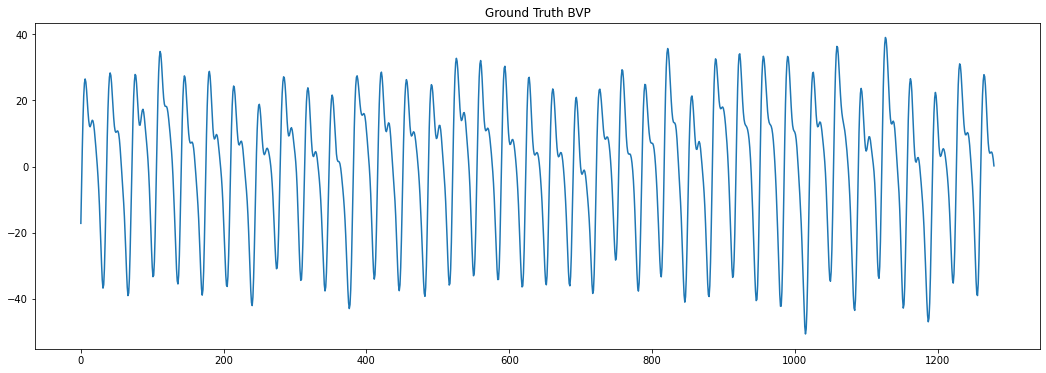

In [204]:
truth = IeeeGroundTruth(5, 1, directory = 'channel_data3')  # subject 2, trial 1
truth.align_rgb_bvp()

# define sample signal interval of interest
interval = 20 * truth.rgb_freq  # 20s times the frame rate from the video
first_frame = 2000
rgb = truth.rgb[first_frame: first_frame + interval]
# bvp has a higher sample rate so need to convert the rgb frames to the corresponding samples
bvp = truth.bvp[truth.align_indices(first_frame): truth.align_indices(first_frame + interval)]

plt.plot(bvp)
plt.title('Ground Truth BVP')

print('BVP Length:', len(bvp))
print('RGB Length:', len(rgb))
print('Length Ratio:', round(len(bvp) / len(rgb), 2))

## 2. Translate raw RGB data into rPPG signal, using chrominance

In [205]:
def chrominance(sig: str or np.array, settings: dict = CHROM_SETTINGS, 
                bounds: Tuple[int, int] = (0, -1), plot: bool = False):
    """"
    Apply the chrominance method to raw RGB data to extract and return
    a raw rPPG signal.
    
    Taken from "Robust Pulse Rate From Chrominance-Based rPPG" by de Haan and Jeanne
    """

    # make sure settings contain necessary info
    for key in CHROM_SETTINGS:
        if key not in settings:
            raise ValueError(f'Settings must contain value for key {key}.')

    # get raw RGB signals
    if isinstance(sig, str):
        r, g, b = _get_rgb_signals(sig, bounds)
    else:
        r = sig[:, 0]
        g = sig[:, 1]
        b = sig[:, 2]
    if plot:
        _plot_signals({'r': r, 'g': g, 'b': b}, 'Raw RGB Signals')
    
    # apply generic detrending and normalization to the raw signals
    r = detrend_w_poly(r)
    g = detrend_w_poly(g)
    b = detrend_w_poly(b)
    r = normalize_signal(r)
    g = normalize_signal(g)
    b = normalize_signal(b)
    if plot:
        _plot_signals({'r': r, 'g': g, 'b': b}, 'Detrended and Normalized RGB Signals')

    # normalize skin tones
    def _tonenorm(v):
        return v / np.sqrt(pow(r, 2) + pow(g, 2) + pow(b, 2))
    r_n, g_n, b_n = _tonenorm(r), _tonenorm(g), _tonenorm(b)
    if plot:
        _plot_signals({'r_n': r_n, 'g_n': g_n, 'b_n': b_n}, 'Normalized RGB Signals')

    # combine the terms
    xs = 3*r_n - 2*g_n
    ys = 1.5*r_n - g_n - 1.5*b_n
    
    # apply bandpass filter to each signal
    xf = bandpass(xs, settings['fr'], settings['freq'], settings['bandpass_order'])
    yf = bandpass(ys, settings['fr'], settings['freq'], settings['bandpass_order'])
    rf = bandpass(r_n, settings['fr'], settings['freq'], settings['bandpass_order'])
    gf = bandpass(g_n, settings['fr'], settings['freq'], settings['bandpass_order'])
    bf = bandpass(b_n, settings['fr'], settings['freq'], settings['bandpass_order'])

    # apply final transformation from the paper
    alpha = np.std(xf) / np.std(yf)
    signal = (3 * (1 - alpha / 2) * rf) - 2 * (1 + alpha / 2) * gf + ((3 * alpha / 2) * bf)

    return signal

def _plot_signals(signals: dict, title: str):
    """"
    Plot the signals in a dictionary.
    """

    for key in signals:
        plt.plot(signals[key], label = key)
    
    plt.title(title)
    plt.legend()
    plt.show()

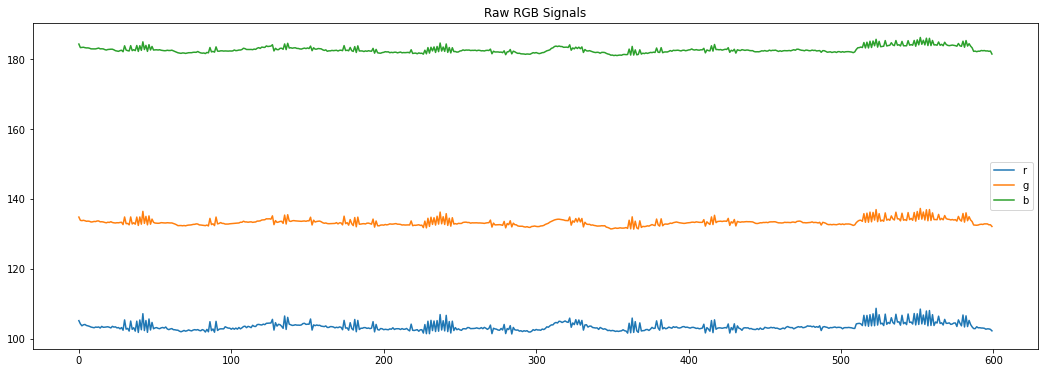

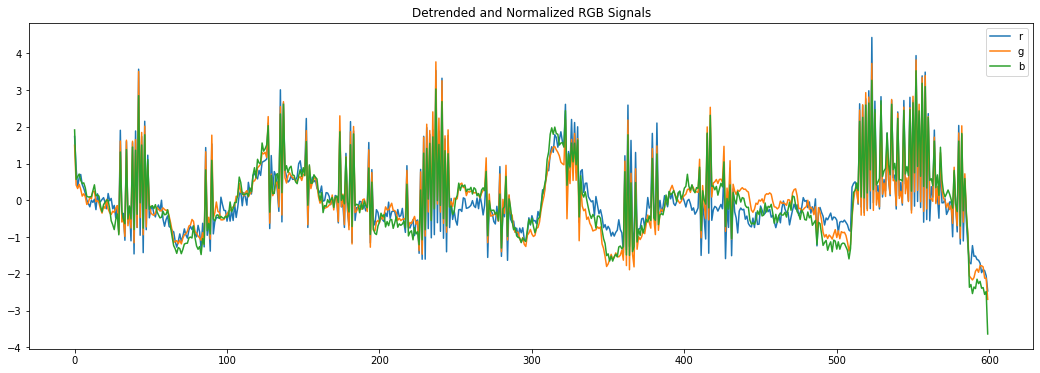

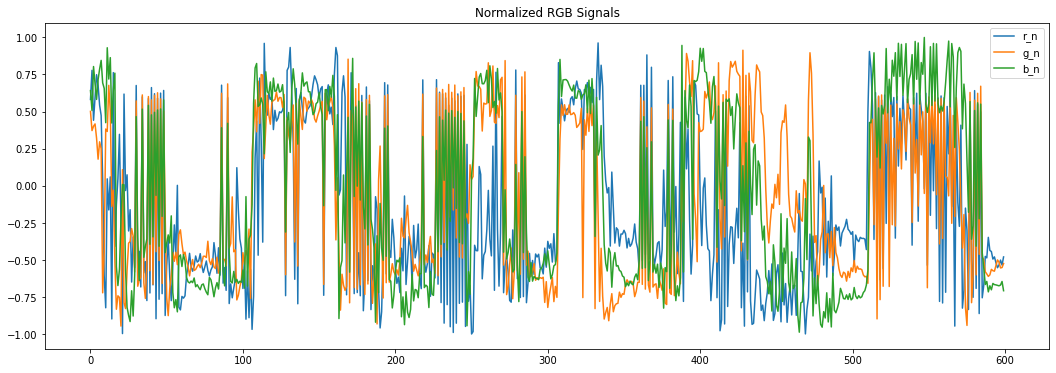

rPPG Signal Length: 600


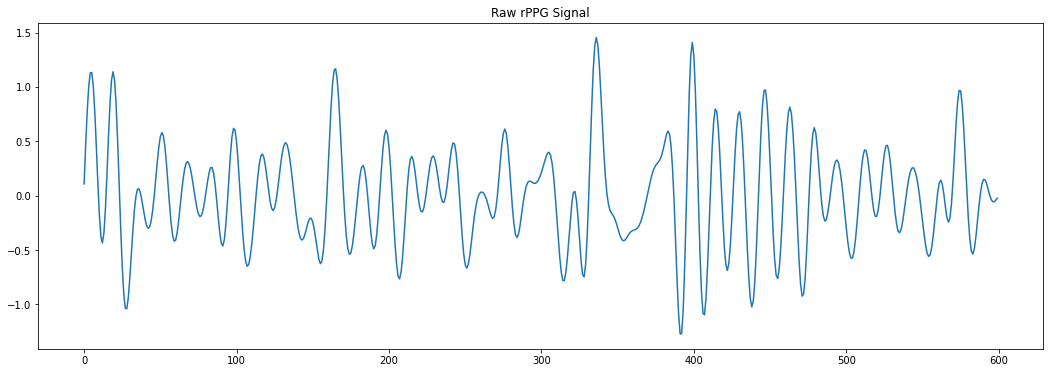

In [206]:
signal = chrominance(rgb, plot = True)
plt.plot(signal)
plt.title('Raw rPPG Signal')

print('rPPG Signal Length:', len(signal))

## 3. (Optional) Apply Wavelet filter to the signal

In [207]:
def apply_wavelet(signal, wave='db2', level=1, cutoff_low=0.7, cutoff_high=3.0, fs=30):
    """
    Given a signal, apply wavelet transform to it and return a
    resulting signal.
    """

    # apply the wavelet transform, repeatedly according the the number of levels given
    filtered_signal = _wavelet_denoise(signal, wave, level)

    # interpolate the filtered signal to match the length of the original signal
    x_old = np.linspace(0, 1, len(filtered_signal))
    x_new = np.linspace(0, 1, len(signal))
    filtered_signal = np.interp(x_new, x_old, filtered_signal)

    # filter the interpolated signal to the desired frequency range
    b, a = _butter_bandpass(cutoff_low, cutoff_high, fs)
    filtered_signal = _filter_signal(filtered_signal, b, a)

    return filtered_signal


def _wavelet_denoise(signal, wavelet, level):
    
    # track signal at the end of each level
    vs = []
    sig = signal.copy()
    for _ in range(level):
        sig, cD = pywt.dwt(sig, wavelet)
        vs.append(sig)

    return vs[-1]


def _filter_signal(signal, b, a):
    """
    Filter a signal using a Butterworth filter with the given
    coefficients b and a.
    """
    filtered_signal = signal.copy()
    if len(b) == len(a) == 1:
        # if both b and a are of length 1, the filter is just a scalar multiplier
        filtered_signal = b * signal
    else:
        # apply the filter
        filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


def _butter_bandpass(lowcut, highcut, fs, order=2):
    """
    Create a Butterworth bandpass filter with the given parameters.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

New Signal Length: 600


Text(0.5, 1.0, 'Signal post-wavelet')

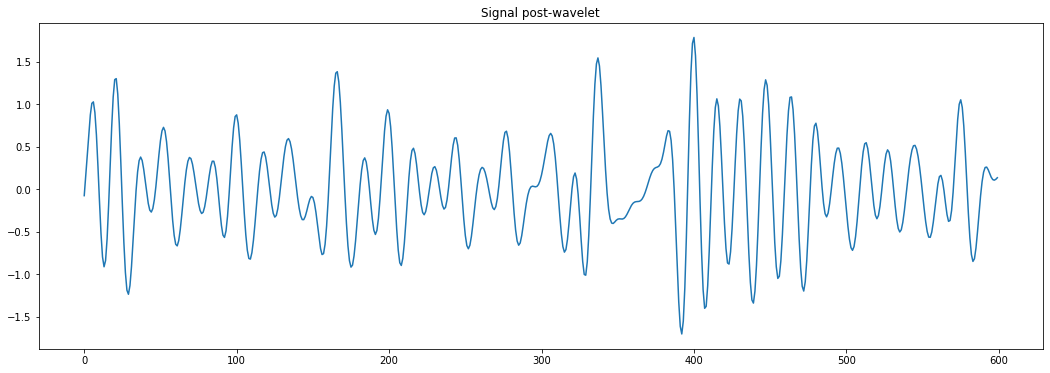

In [208]:
signal = apply_wavelet(signal, wave = 'db2', level = 1)
print('New Signal Length:', len(signal))
plt.plot(signal)
plt.title('Signal post-wavelet')

## 4. Normalize amplitude to 1 to simplify later processing

New Signal Length: 600


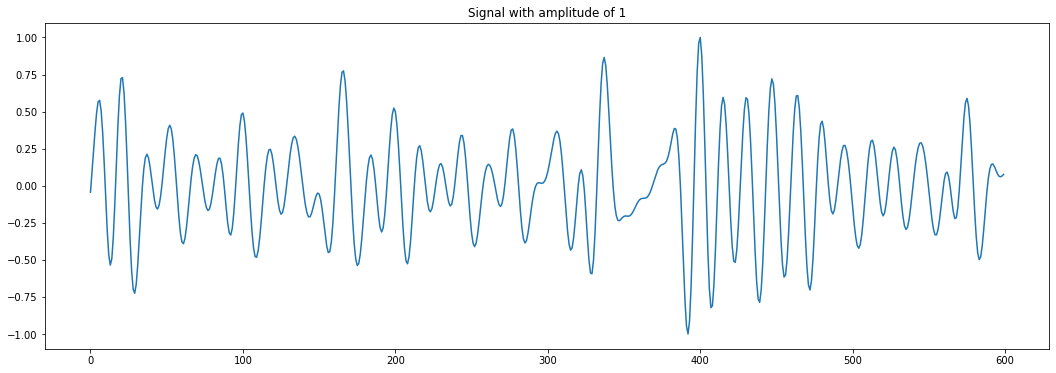

In [209]:
signal = normalize_amplitude_to_1(signal)
print('New Signal Length:', len(signal))
plt.title('Signal with amplitude of 1')
plt.plot(signal)

## 5. Apply n-moving average to the signal, and to the bvp

Length of signal: 595


Text(0.5, 1.0, 'Signal post moving average of 10')

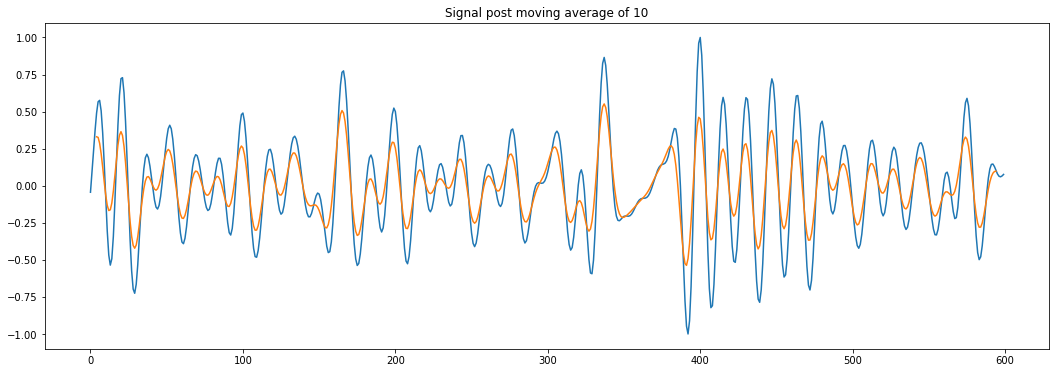

In [210]:
window = CHROM_SETTINGS['moving_avg_window']
window = 10

# apply the moving average filter
orig = signal.copy()
signal = n_moving_avg(signal, window)

# add empty elements to the beginning of the array to maintain proper
# positioning of the elements
signal = [None]*((window - 1) // 2) + list(signal)
print('Length of signal:', len(signal))
signal = np.array(signal)

plt.plot(orig)
plt.plot(signal)
plt.title(f'Signal post moving average of {window}')

Length of BVP: 1273


Text(0.5, 1.0, 'BVP post moving average of 15')

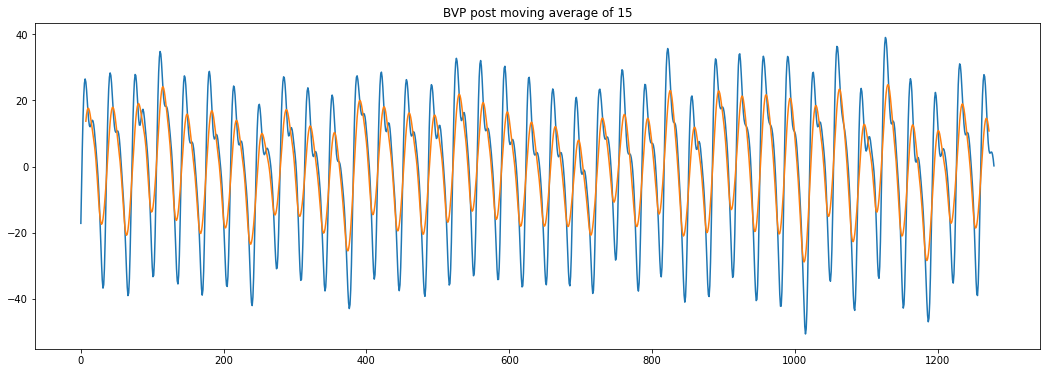

In [211]:
bvp_window = 15

# apply the moving average filter
orig = bvp.copy()
bvp = n_moving_avg(bvp, bvp_window)

# add empty elements to the beginning of the array to maintain proper
# positioning of the elements
bvp = [None]*((bvp_window - 1) // 2) + list(bvp)
print('Length of BVP:', len(bvp))
bvp = np.array(bvp)

plt.plot(orig)
plt.plot(bvp)
plt.title(f'BVP post moving average of {bvp_window}')

## 6. Get peaks from smoothed rPPG

In [212]:
def get_peaks(signal: np.ndarray, fr: int, max_freq: float, peak_height: float,
    slice_filter_thresh: int, perc1: float, perc2: float,
    with_min_dist: bool = True, with_additional_filtering: bool = True, prominence = 0.5):
    """
    The current standard method for peak detection. Includes the option to use the _filter_peaks
    method for even more aggressive filtering.
    """
    
    # skip any None values at the beggining of the signal
    first_index = None
    for i in range(len(signal)):
        if signal[i] is not None:
            first_index = i
            break
    signal = signal[first_index: ]

    if with_min_dist:
        min_dist = fr // max_freq
    else:
        min_dist = 1
    
    print('With min dist:', min_dist)
    peaks, _ = find_peaks(signal, height = peak_height, prominence = 0.05, distance = min_dist)

    if with_additional_filtering:
        peaks = _filter_peaks(signal, peaks, fr, slice_filter_thresh, perc1, perc2)
    
    return [p + first_index for p in peaks]


def _filter_peaks(signal: np.ndarray, peaks: np.ndarray, fr: int,
    slice_filter_thresh: int, perc1: float, perc2: float):
    """
    Filter peaks with the intent of trying to peaks that are "definitely" noise.
    """

    # first, remove peaks that aren't sufficienrtly above the perc2 percentile. I intentionally
    # am comparing the peaks to the entire array, and not just the set of peaks, because I'm not
    # making the assumption that a certain percentage of peaks will inherently be noisy. However,
    # I am making the assumption that if the peak is insufficiently clear of a certain baseline of
    # the entire signal, then it must be noise.
    peaks = np.array([p for p in peaks if signal[p] >= np.percentile(signal, perc2)])   
    
    # Peak Walk: remove peaks that are close together, that aren't sufficiently large relative to the
    # entire signal. This percentile (perc1) is more stringent than the one used in the first step.
    for i in range(0, len(signal) - fr, fr):
        
        j = i + fr
        slce = peaks[(peaks >= i) & (peaks < j)]
        
        if len(slce) > slice_filter_thresh:
            to_remove = [i for i in range(len(slce)) if signal[slce[i]] < np.percentile(signal[slce], perc1)]
            peaks = peaks[~np.isin(peaks, [slce[i] for i in to_remove])]
            # removed += len(to_remove)
    
    return peaks

With min dist: 12.0
[100.0, 138.46153846153845, 100.0, 128.57142857142856, 112.5, 94.73684210526316, 120.0, 56.25, 94.73684210526316, 128.57142857142856, 100.0, 138.46153846153845, 128.57142857142856, 100.0, 120.0, 64.28571428571428, 105.88235294117648, 112.5, 40.909090909090914, 100.0, 112.5, 120.0, 105.88235294117648, 112.5, 105.88235294117648, 128.57142857142856, 100.0, 120.0, 105.88235294117648, 60.0]
Len Signal: 595


Text(0.5, 1.0, 'Detected peaks')

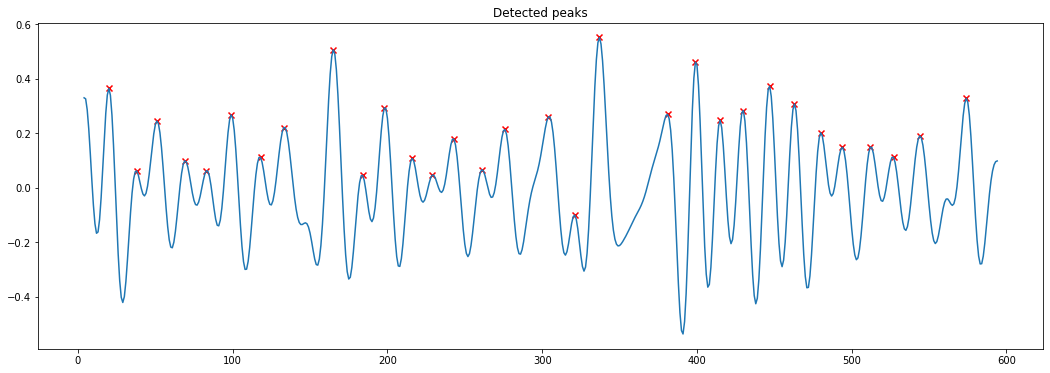

In [213]:
peaks = get_peaks(
        signal,
        CHROM_SETTINGS['fr'],
        CHROM_SETTINGS['freq'][1],
#         CHROM_SETTINGS['peak_height'],
        -1,
        CHROM_SETTINGS['slice_filter_thresh'],
        CHROM_SETTINGS['stringent_perc'],
        CHROM_SETTINGS['non_stringent_perc'],
        with_min_dist = True,
        with_additional_filtering = False
)

diff = np.diff(peaks)
print([60 / (d / 30) for d in diff])

print('Len Signal:', len(signal))
plt.plot(signal)
plt.scatter([p for p in peaks], [signal[p] for p in peaks], marker='x', color='r')
plt.title('Detected peaks')

With min dist: 12.0
Len Signal: 595


Text(0.5, 1.0, 'Detected Valleys')

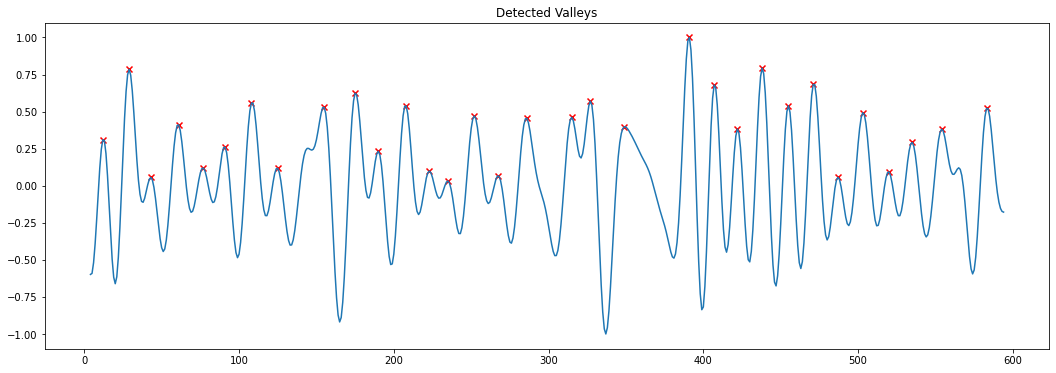

In [223]:
signal_neg = [None if v is None else -v for v in signal]
valleys = get_peaks(
        signal_neg,
        CHROM_SETTINGS['fr'],
        CHROM_SETTINGS['freq'][1],
#         CHROM_SETTINGS['peak_height'],
        -1,
        CHROM_SETTINGS['slice_filter_thresh'],
        CHROM_SETTINGS['stringent_perc'],
        CHROM_SETTINGS['non_stringent_perc'],
        with_min_dist = True,
        with_additional_filtering = False
)

print('Len Signal:', len(signal))
plt.plot(signal_neg)
plt.scatter([v for v in valleys], [signal_neg[v] for v in valleys], marker='x', color='r')
plt.title('Detected Valleys')

In [215]:
bvp_index = np.array(list(range(len(bvp)))) / 64
signal_index = np.array(list(range(len(signal)))) / 30
adjusted_peaks = [p / 30 for p in peaks]

bvp = normalize_amplitude_to_1(bvp)
signal = normalize_amplitude_to_1(signal)

Lengths: BVP 1273 rPPG 595
Effective heartrate 0 --> 1: 100.0
Effective heartrate 1 --> 2: 138.46153846153845
Effective heartrate 2 --> 3: 100.00000000000003
Effective heartrate 3 --> 4: 128.57142857142853
Effective heartrate 4 --> 5: 112.50000000000003
Effective heartrate 5 --> 6: 94.73684210526316
Effective heartrate 6 --> 7: 119.9999999999999
Effective heartrate 7 --> 8: 56.250000000000014
Effective heartrate 8 --> 9: 94.7368421052631
Effective heartrate 9 --> 10: 128.57142857142878
Effective heartrate 10 --> 11: 99.99999999999991
Effective heartrate 11 --> 12: 138.4615384615384
Effective heartrate 12 --> 13: 128.57142857142878
Effective heartrate 13 --> 14: 100.00000000000006
Effective heartrate 14 --> 15: 120.0
Effective heartrate 15 --> 16: 64.28571428571426
Effective heartrate 16 --> 17: 105.88235294117652
Effective heartrate 17 --> 18: 112.50000000000003
Effective heartrate 18 --> 19: 40.90909090909091
Effective heartrate 19 --> 20: 99.99999999999976
Effective heartrate 20 --> 

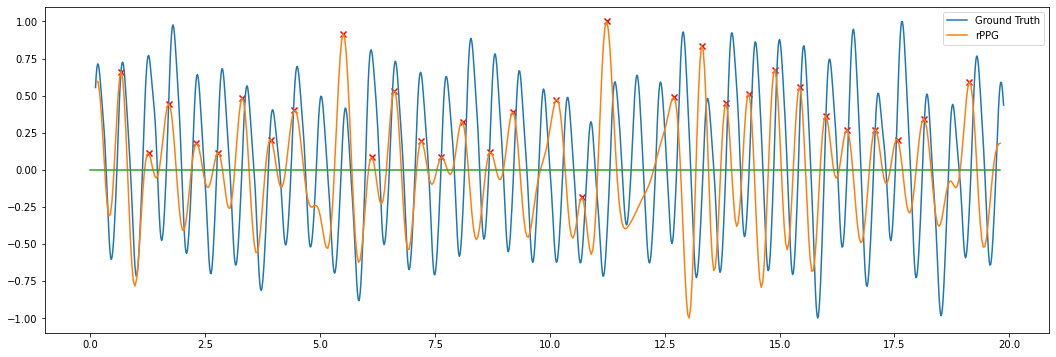

In [216]:
print('Lengths:', f'BVP {len(bvp)}', f'rPPG {len(signal)}')
plt.plot(bvp_index, bvp, label = 'Ground Truth')
plt.plot(signal_index, signal, label = 'rPPG')
plt.plot(signal_index, [0 for _ in range(len(signal_index))])
plt.scatter(adjusted_peaks, [signal[p] for p in peaks], color = 'red', marker = 'x')
plt.legend()

# list the time in between each detected peak in the rPPG
for i in range(1, len(adjusted_peaks)):
    print(f'Effective heartrate {i - 1} --> {i}:', 60 / (adjusted_peaks[i] - adjusted_peaks[i - 1]))

## 7. Get peaks for ground truth

With min dist: 1
Len BVP: 1273


Text(0.5, 1.0, 'Detected peaks')

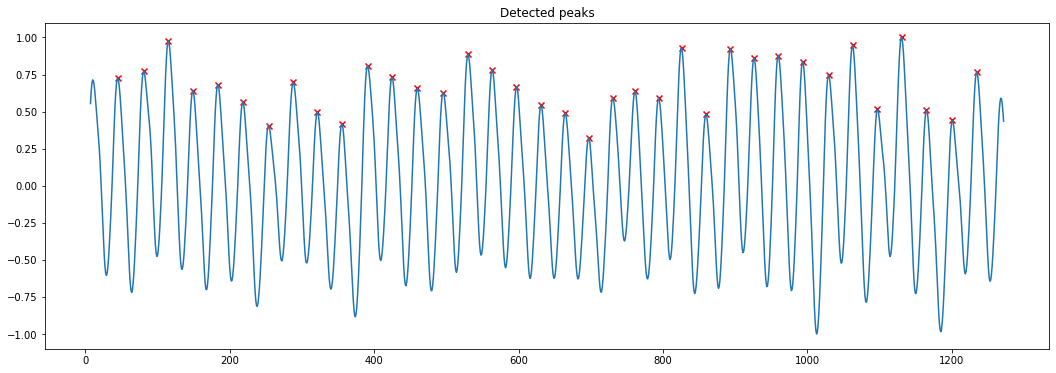

In [217]:
true_peaks = get_peaks(
        bvp,
        CHROM_SETTINGS['fr'],
        CHROM_SETTINGS['freq'][1],
        0,
        CHROM_SETTINGS['slice_filter_thresh'],
        CHROM_SETTINGS['stringent_perc'],
        CHROM_SETTINGS['non_stringent_perc'],
        with_min_dist = False,
        with_additional_filtering = False
)

proms = peak_prominences(bvp, true_peaks)[0]
true_peaks = [true_peaks[i] for i in range(len(true_peaks)) if proms[i] >= 0.6]

print('Len BVP:', len(bvp))
plt.plot(bvp)
plt.scatter([p for p in true_peaks], [bvp[p] for p in true_peaks], marker = 'x', color = 'r')
plt.title('Detected peaks')

# Calculate and compare the HR estimates

In [218]:
def get_ibis(peaks, fr = 30, with_valleys = False):
    ibis = []
    for i in range(1, len(peaks)):

        if with_valleys:
            peak_diff = peaks[i][0] - peaks[i - 1][0]
        else: 
            peak_diff = peaks[i] - peaks[i - 1]
        
        ibi = peak_diff / fr

        if with_valleys and peaks[i][1] != peaks[i - 1][1]:
            ibi *= 2
        
        ibis.append(ibi)

    return ibis

def get_hr(ibis):
    return 60 / np.mean(ibis)

In [219]:
print('Num true peaks:', len(true_peaks))
print('Num estimated peaks:', len(peaks))

Num true peaks: 36
Num estimated peaks: 31


In [220]:
true_ibis = get_ibis(true_peaks, fr = 64)
ibis = get_ibis(peaks, fr = 30)

print('Ground Truth Heart Rate:', get_hr(true_ibis))
print('Estimated Heart Rate:', get_hr(ibis))

Ground Truth Heart Rate: 112.94117647058823
Estimated Heart Rate: 97.47292418772564
